In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sp
import scipy.ndimage
from skimage import data, color
from skimage.transform import hough_circle
from skimage.feature import peak_local_max, canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte

In [2]:
seal_img_filename = 'seal_cup_tooth.tif'
seal_img_full = cv2.imread(seal_img_filename)

In [3]:
seal_img_full.shape
ds_vals = 1.0/ np.array([1,2,4,8,16])

seal_img_gray = cv2.cvtColor(seal_img_full,cv2.COLOR_RGB2GRAY)
multi_res_pyr = [cv2.resize(seal_img_gray, dsize = (0,0),fx = ds_mult, fy= ds_mult, interpolation = cv2.INTER_AREA) for ds_mult in ds_vals]


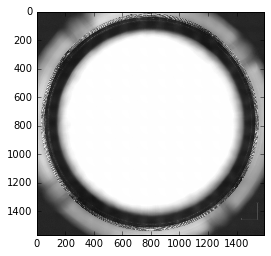

In [4]:
IDX_USED = 3
plt.imshow(multi_res_pyr[IDX_USED],cmap='gray')

In [5]:
#Helper Functions for plotting
def plot_directional_intensity(data, origin=None):
    """Makes a cicular histogram showing average intensity binned by direction
    from "origin" for each band in "data" (a 3D numpy array). "origin" defaults
    to the center of the image."""

    # Make cartesian coordinates for the pixel indicies
    # (The origin defaults to the center of the image)
    x, y = index_coords(data, origin)

    # Convert the pixel indices into polar coords.
    r, theta = cart2polar(x, y)

    # Plot...
    plt.figure(figsize=(10,10))
    plt.subplot(1,1,1, projection='polar')
    theta, data = theta.flatten(), data.flatten()
    intensities, theta_bins = bin_by(data, theta)
    mean_intensity = [np.mean(intensity) for intensity in intensities]
    width = np.diff(theta_bins)[0]
    plt.bar(theta_bins, mean_intensity, width=width)
    plt.yticks([])
    plt.suptitle('Average intensity as a function of direction')

def plot_polar_image(data, origin=None, r_range=None):
    """Plots an image reprojected into polar coordinages with the origin
    at "origin" (a tuple of (x0, y0), defaults to the center of the image)"""
    polar_grid, r, theta = reproject_image_into_polar(data, origin, r_range)
    plt.figure(figsize = (14,6))
    plt.imshow(polar_grid, extent=(theta.min(), theta.max(), r.max(), r.min()),cmap = 'gray')
    plt.axis('auto')
    plt.ylim(plt.ylim()[::-1])
    plt.xlabel('Theta Coordinate (radians)')
    plt.ylabel('R Coordinate (pixels)')
    plt.title('Image in Polar Coordinates')
    return polar_grid,r,theta

def index_coords(data, origin=None):
    """Creates x & y coords for the indicies in a numpy array "data".
    "origin" defaults to the center of the image. Specify origin=(0,0)
    to set the origin to the lower left corner of the image."""
    ny, nx = data.shape[:2]
    if origin is None:
        origin_x, origin_y = nx // 2, ny // 2
    else:
        origin_x, origin_y = origin
    x, y = np.meshgrid(np.arange(nx), np.arange(ny))
    x -= origin_x
    y -= origin_y
    return x, y

def cart2polar(x, y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return r, theta

def polar2cart(r, theta):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y


def bin_by(x, y, nbins=60):
    """Bin x by y, given paired observations of x & y.
    Returns the binned "x" values and the left edges of the bins."""
    bins = np.linspace(y.min(), y.max(), nbins+1)
    # To avoid extra bin for the max value
    bins[-1] += 1 

    indicies = np.digitize(y, bins)

    output = []
    for i in range(1, len(bins)):
        output.append(x[indicies==i])

    # Just return the left edges of the bins
    bins = bins[:-1]

    return output, bins

def reproject_image_into_polar(data, origin=None, r_range=None):
    """Reprojects a 3D numpy array ("data") into a polar coordinate system.
    "origin" is a tuple of (x0, y0) and defaults to the center of the image."""
    ny, nx = data.shape[:2]
    if origin is None:
        origin = (nx//2, ny//2)

    # Determine that the min and max r and theta coords will be...
    x, y = index_coords(data, origin=origin)
    r, theta = cart2polar(x, y)

    # Make a regular (in polar space) grid based on the min and max r & theta
    if (r_range == None):
      r_i = np.linspace(r.min(), r.max(), nx)
    else:
      r_i = np.linspace(min(r_range), max(r_range), nx)


    theta_i = np.linspace(theta.min(), theta.max(), ny)
    theta_grid, r_grid = np.meshgrid(theta_i, r_i)

    # Project the r and theta grid back into pixel coordinates
    xi, yi = polar2cart(r_grid, theta_grid)
    xi += origin[0] # We need to shift the origin back to 
    yi += origin[1] # back to the lower-left corner...
    xi, yi = xi.flatten(), yi.flatten()
    coords = np.vstack((xi, yi)) # (map_coordinates requires a 2xn array)

  
    zi = sp.ndimage.map_coordinates(data, coords, order=1)
    output = zi.reshape((nx, ny))
    return output, r_i, theta_i




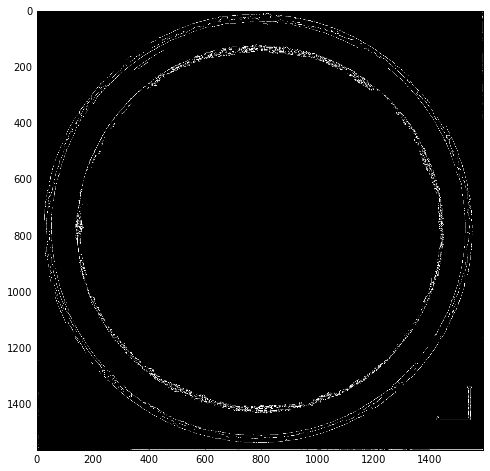

In [6]:
#Work on IDX_USED res image
img =  multi_res_pyr[IDX_USED].copy()
ds_val = ds_vals[IDX_USED]
img_dims = img.shape

#Detect and plot edges
edges = canny(img, sigma=3, low_threshold=20, high_threshold=30)
plt.figure(figsize=(8,8))
plt.imshow(edges,cmap ='gray')


In [7]:
# Detect circles using hough transform
min_r = 0.9*img_dims[0]/2.0
max_r = 1.0*img_dims[0]/2.0
    
hough_radii = np.arange(min_r, max_r, 1)
hough_res = hough_circle(edges, hough_radii)

In [8]:
#Find peak intensity circles
centers = []
accums = []
radii = []

for radius, h in zip(hough_radii, hough_res):
    # For each radius, extract a circle
    num_peaks = 1
    peaks = peak_local_max(h, num_peaks=num_peaks)
    centers.extend(peaks)
    accums.extend(h[peaks[:, 0], peaks[:, 1]])
    radii.extend([radius] * num_peaks)

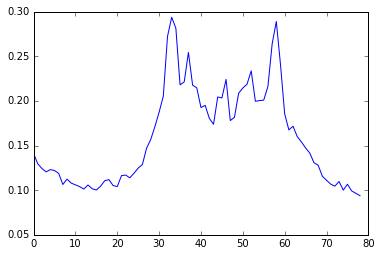

In [9]:
#Find beginning and end of lip
accums = np.array(accums)
min_val = np.min(accums)
#Find first index greater than 
start_idx = np.argmax(accums > 2*min_val)
#Find last index greater than
rev_view = accums[::-1]
end_idx = len(accums) - np.argmax(rev_view> 2* min_val) - 1
plt.plot(accums)

Range of plot search: 31 -> 73
Center for inner radius: (777,789)
Center for outer radius: (776,787)
Avg Center: [776 788]
Radius search range: 734 --> 776


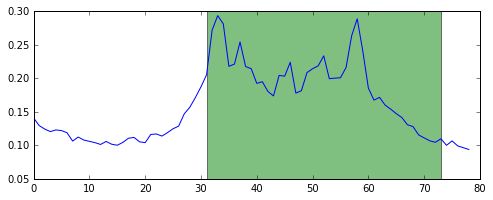

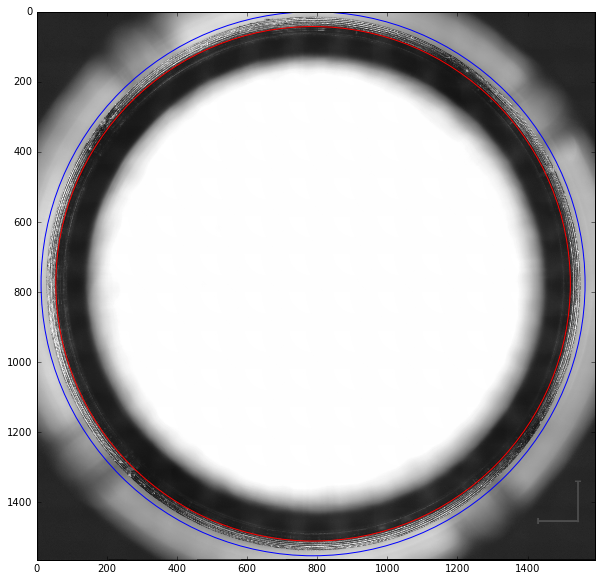

In [10]:
#Find lip, set search range to beginning and past end of it
lipsize = end_idx - start_idx

min_idx = start_idx
max_idx = int(end_idx+ lipsize/2)
if (max_idx > len(radii)):
  max_idx = len(radii)-1
print ("Range of plot search: {} -> {}".format(min_idx,max_idx))
#Plot the peaks in the transform - these will be the beginning and end of the threaded portion
plt.figure (figsize = (8,3))
plt.plot(accums)
ax = plt.axvspan(min_idx, max_idx, facecolor='g', alpha=0.5)

#For min and max radii extract circle center
radius_range = []
center_vals = []
radius = int(radii[min_idx])
radius_range.append(radius)
center_x, center_y = centers[min_idx]
print ("Center for inner radius: ({},{})".format(center_x,center_y))

center_vals.append([center_x,center_y])
radius = int(radii[max_idx])
radius_range.append(radius)
#Use end idx, not max for circle center, since end_idx was the outer most circle
center_x, center_y = centers[end_idx]
print ("Center for outer radius: ({},{})".format(center_x,center_y))
center_vals.append([center_x,center_y])


center = np.round(np.mean(center_vals,axis=0)).astype(int)
print ("Avg Center: {}".format(center))
print ("Radius search range: {} --> {}".format(radius_range[0],radius_range[1]))

fig = plt.figure(figsize=(10,10))
plt.imshow(multi_res_pyr[IDX_USED],cmap='gray')
circle0 = plt.Circle((center[1],center[0]),radius_range[0],color=(1,0,0),fill=False)
fig.add_subplot(111).add_artist(circle0)
circle1 = plt.Circle((center[1],center[0]),radius_range[1],color=(0,0,1),fill=False)
fig.add_subplot(111).add_artist(circle1)


Avg Center: [3104 3152]
Radius search range: 2936 --> 3104


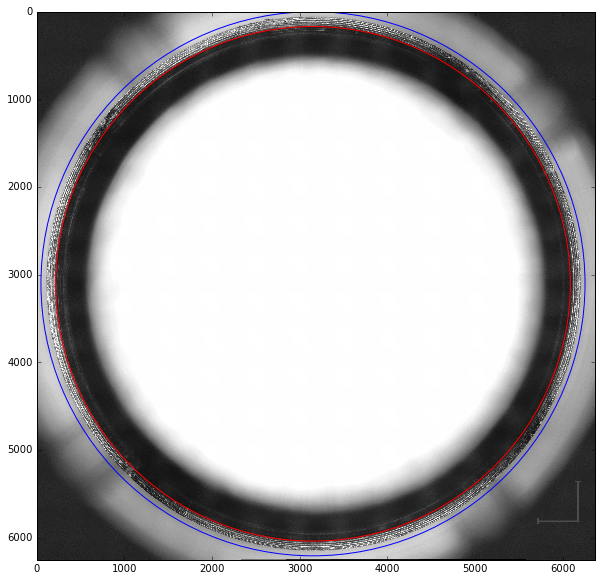

In [11]:
#Use full resolution image,scale circle center etc to use it
IDX_USED_NEW = 1
scale_factor =  (1.0 / ds_vals[IDX_USED]) / (1.0 / ds_vals[IDX_USED_NEW])

center = (np.array(center) * scale_factor).astype(np.int64)
radius_range = (np.array(radius_range) * scale_factor).astype(np.int64)
print ("Avg Center: {}".format(center))
print ("Radius search range: {} --> {}".format(radius_range[0],radius_range[1]))

fig = plt.figure(figsize=(10,10))
plt.imshow(multi_res_pyr[IDX_USED_NEW],cmap='gray')
circle0 = plt.Circle((center[1],center[0]),radius_range[0],color=(1,0,0),fill=False)
fig.add_subplot(111).add_artist(circle0)
circle1 = plt.Circle((center[1],center[0]),radius_range[1],color=(0,0,1),fill=False)
fig.add_subplot(111).add_artist(circle1)

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:93: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


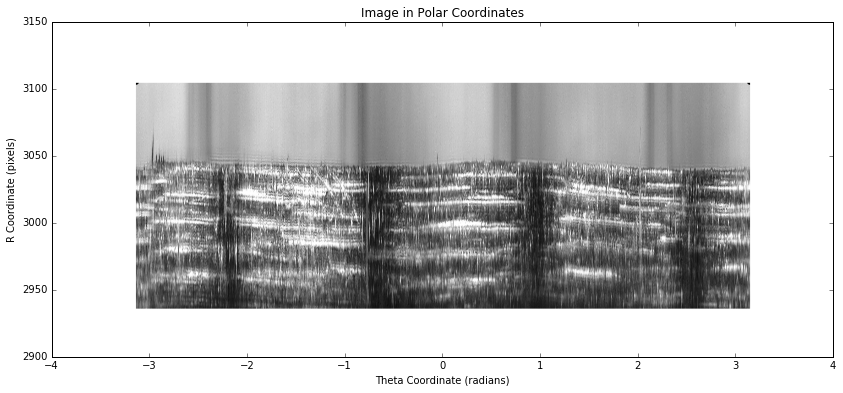

In [12]:
#Plot a projection of the search range - this should shown the lip and its edge nicely
polar_grid,r,theta = plot_polar_image(multi_res_pyr[IDX_USED_NEW],center, radius_range)

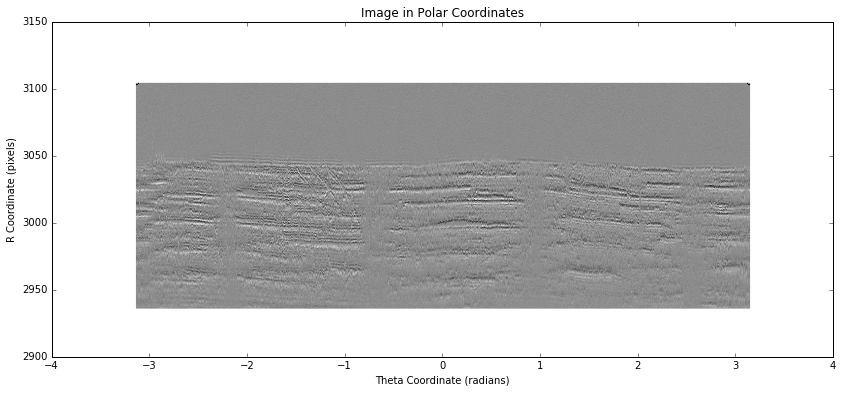

In [83]:
from skimage.filters import sobel_h
filtered_sobel_h = sobel_h(polar_grid)

plt.figure(figsize = (14,6))
plt.imshow(filtered_sobel_h, extent=(theta.min(), theta.max(), r.max(), r.min()),cmap = 'gray')
plt.axis('auto')
plt.ylim(plt.ylim()[::-1])
plt.xlabel('Theta Coordinate (radians)')
plt.ylabel('R Coordinate (pixels)')
plt.title('Image in Polar Coordinates')

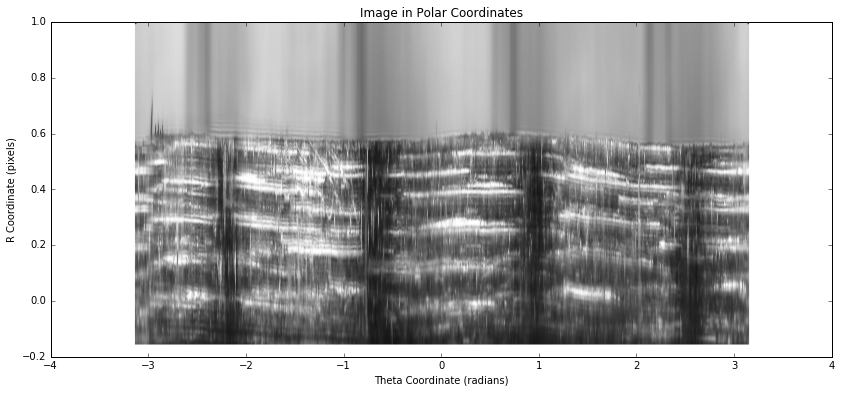

In [205]:
from skimage.restoration import denoise_tv_chambolle, denoise_bilateral
tv_denoised = denoise_tv_chambolle(polar_grid, weight=0.5)

plt.figure(figsize = (14,6))
plt.imshow(tv_denoised, extent=(theta.min(), theta.max(), r.max(), r.min()),cmap = 'gray')
plt.axis('auto')
plt.ylim(plt.ylim()[::-1])
plt.xlabel('Theta Coordinate (radians)')
plt.ylabel('R Coordinate (pixels)')
plt.title('Image in Polar Coordinates')

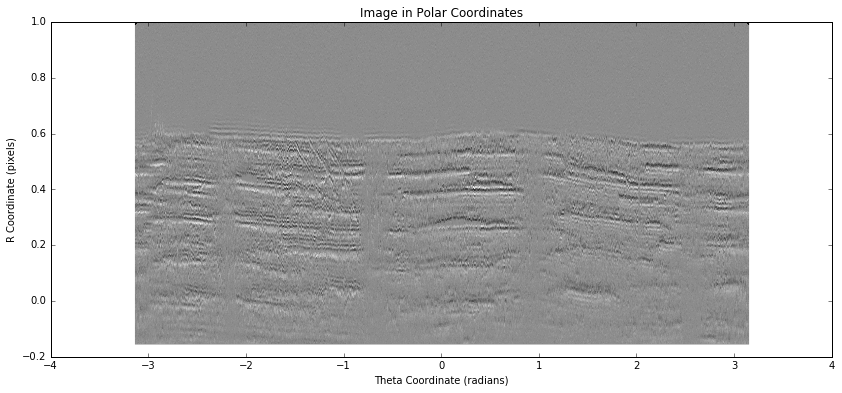

In [346]:
from skimage.filters import sobel_h
filtered_sobel_h = sobel_h(polar_grid)

plt.figure(figsize = (14,6))
plt.imshow(filtered_sobel_h, extent=(theta.min(), theta.max(), r.max(), r.min()),cmap = 'gray')
plt.axis('auto')
plt.ylim(plt.ylim()[::-1])
plt.xlabel('Theta Coordinate (radians)')
plt.ylabel('R Coordinate (pixels)')
plt.title('Image in Polar Coordinates')

In [353]:
from scipy.stats import norm

vals = []
background_samples = 1000
mean,var,std = bayes_mvs(filtered_sobel_h[0:background_samples,:], alpha=0.9)
norm_background_dist = norm(mean[0],std[0])

for c in range (filtered_sobel_h.shape[1]):
  col = filtered_sobel_h[:,c][::-1]
  vals.append(np.argmax(norm_background_dist.cdf(col)<0.01))
  
edge_vals = np.array(vals)  
ker = (1.0/20.0)*np.ones(20)
edge_vals_smooth = np.convolve(edge_vals, ker, mode='same')


In [ ]:
from skimage.filters import sobel_h
filtered_sobel_h = sobel_h(polar_grid)

plt.figure(figsize = (14,6))
plt.imshow(polar_grid, extent=(theta.min(), theta.max(), r.max(), r.min()),cmap = 'gray')
plt.axis('auto')
plt.ylim(plt.ylim()[::-1])
plt.xlabel('Theta Coordinate (radians)')
plt.ylabel('R Coordinate (pixels)')
plt.title('Image in Polar Coordinates')

theta_vals = np.linspace(theta.min(), theta.max(),polar_grid.shape[1])
rvals = np.linspace(r.max(), r.min(),polar_grid.shape[0])
edge_radius = rvals[edge_vals.astype(np.int)]
plt.plot(theta_vals,edge_radius,'r')

edge_radius_smooth = rvals[edge_vals_smooth.astype(np.int)]
plt.plot(theta_vals,edge_radius_smooth,'b')

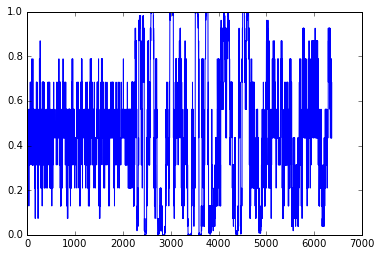

In [348]:
plt.plot(norm_background_dist.cdf(col))